In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.8.0
    Uninstalling setuptools-59.8.0:
      Successfully uninstalled setuptools-59.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.6.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
opentelemetry-api 1.17.0 requires importlib-metadata~=6.0.0, but you have importlib-metadata 5.2.0 which is incompatible.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.23.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 9.5 MB/s eta 0:00:00
  Preparing metada

In [3]:
pip install bokeh==2.0.1

Note: you may need to restart the kernel to use updated packages.


In [4]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "ahmadhamde"
kaggle_key = "4a132a9491812ffaaf2bb8eed0347c94"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

In [6]:
import pandas as pd
from autogluon.tabular import TabularPredictor

In [7]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv('../input/bike-sharing-demand/train.csv')
train['datetime'] = pd.to_datetime(train['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [9]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('../input/bike-sharing-demand/test.csv')
test['datetime'] = pd.to_datetime(test['datetime'])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [10]:
# Same thing as train and test dataset
submission = pd.read_csv('../input/bike-sharing-demand/sampleSubmission.csv')
submission['datetime'] = pd.to_datetime(submission['datetime'])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [11]:
train.drop(columns = ['casual', 'registered'], inplace = True)

In [12]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [13]:
predictor = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(train_data = train, presets = 'best_quality', time_limit = 600)

No path specified. Models will be saved in: "AutogluonModels/ag-20230611_150946/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230611_150946/"
AutoGluon Version:  0.7.0
Python Version:     3.10.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed May 31 10:45:00 UTC 2023
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fe

In [14]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L3  -54.692070      67.373214  500.520564                0.000896           0.241043            3       True         10
1         LightGBM_BAG_L2  -54.712649      46.340335  388.999595                2.570295          47.508154            2       True          9
2       LightGBMXT_BAG_L2  -60.810676      64.802023  452.771367               21.031982         111.279926            2       True          8
3   KNeighborsDist_BAG_L1  -84.175461       0.057796    0.020152                0.057796           0.020152            1       True          2
4     WeightedEnsemble_L2  -84.175461       0.061408    0.612631                0.003612           0.592479            2       True          7
5   KNeighborsUnif_BAG_L1 -101.644380       0.059231    1.048217                

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.64437969927306,
  'KNeighborsDist_BAG_L1': -84.17546135232182,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54835939455667,
  'CatBoost_BAG_L1': -131.6311992684719,
  'WeightedEnsemble_L2': -84.17546135232182,
  'LightGBMXT_BAG_L2': -60.810676142684194,
  'LightGBM_BAG_L2': -54.71264869411645,
  'WeightedEnsemble_L3': -54.6920700637078},


In [15]:
predictions = predictor.predict(test)
predictions.head()

0    39.272270
1    52.074448
2    57.708389
3    59.318996
4    60.273335
Name: count, dtype: float32

In [16]:
predictor.get_model_best()


'WeightedEnsemble_L3'

In [17]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()
# How many negative values do we have?
(predictions < 0).sum()
# Set them to zero
predictions[predictions < 0] = 0

In [18]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [19]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

E0611 15:21:02.060883169    1821 completion_queue.cc:739]              Kick failed: UNKNOWN:Bad file descriptor {created_time:"2023-06-11T15:21:02.060869873+00:00", errno:9, os_error:"Bad file descriptor", syscall:"eventfd_write"}
100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 69.4kB/s]
Successfully submitted to Bike Sharing Demand

In [20]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2023-06-11 15:21:06  first raw submission               complete  1.88160      1.88160       
submission_new_hpo.csv       2023-06-11 13:39:58  new features with hyperparameters  complete  0.71411      0.71411       
submission_new_features.csv  2023-06-11 13:28:50  new features                       complete  0.65979      0.65979       
submission.csv               2023-06-11 13:17:02  first raw submission               complete  1.88138      1.88138       


array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'count'}>, <Axes: >, <Axes: >]],
      dtype=object)

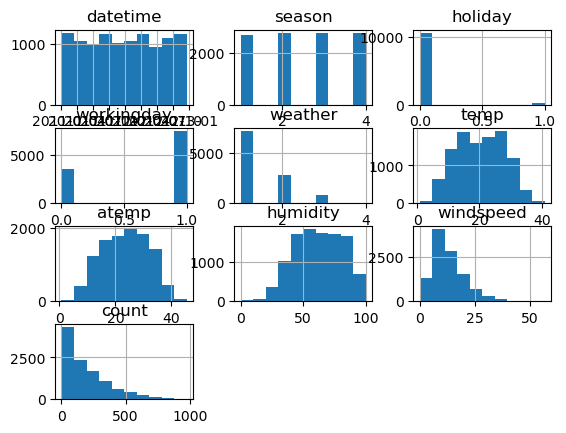

In [21]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist()

In [22]:
# create a new feature
train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour

test['year'] = test.datetime.dt.year
test['month'] = test.datetime.dt.month
test['day'] = test.datetime.dt.day
test['hour'] = test.datetime.dt.hour

In [23]:
train["season"] = train["season"].astype('category')
train["weather"] = train["weather"].astype('category')
test["season"] = test["season"].astype('category')
test["weather"] = test["weather"].astype('category')

In [24]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,4


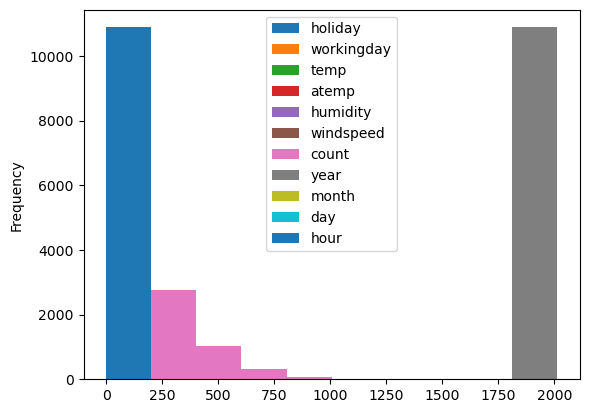

In [25]:
train.plot(kind = 'hist');

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'holiday'}>,
        <Axes: title={'center': 'workingday'}>],
       [<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>],
       [<Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'count'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>,
        <Axes: title={'center': 'hour'}>]], dtype=object)

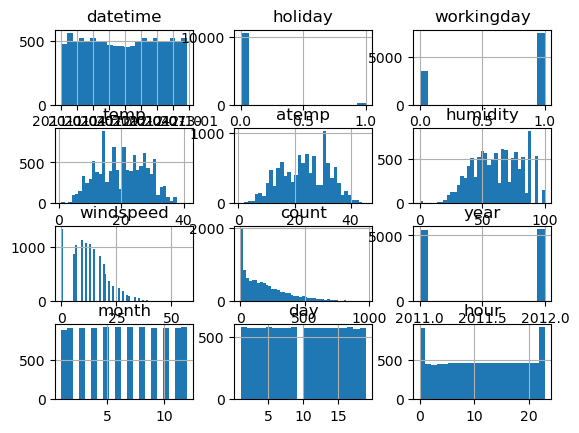

In [26]:
# View histogram of all features again now with the hour feature
train.hist(bins="auto")

In [27]:
predictor_new_features = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(train_data = train, presets = 'best_quality', time_limit = 600)

No path specified. Models will be saved in: "AutogluonModels/ag-20230611_152117/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230611_152117/"
AutoGluon Version:  0.7.0
Python Version:     3.10.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed May 31 10:45:00 UTC 2023
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

In [28]:
predictor_new_features.fit_summary()


*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.416327      89.861839  544.561711                0.000826           0.302137            3       True         11
1          LightGBM_BAG_L2  -30.611487      86.037464  426.838055                1.217305          52.276918            2       True          9
2        LightGBMXT_BAG_L2  -31.295702      87.804850  438.043137                2.984691          63.482000            2       True          8
3   RandomForestMSE_BAG_L2  -31.706135      85.659016  428.500656                0.838857          53.939519            2       True         10
4      WeightedEnsemble_L2  -32.314539      84.110161  340.484658                0.002289           0.617716            2       True          7
5          LightGBM_BAG_L1  -33.917339      15.486524  100.696541         

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.64437969927306,
  'KNeighborsDist_BAG_L1': -84.17546135232182,
  'LightGBMXT_BAG_L1': -34.34599701170154,
  'LightGBM_BAG_L1': -33.91733862651761,
  'RandomForestMSE_BAG_L1': -38.30612025079756,
  'CatBoost_BAG_L1': -69.54838747347921,
  'WeightedEnsemble_L2': -32.31453948099807,
  'LightGBMXT_BAG_L2': -31.295702402010075,
  'LightGBM_BAG_L2': -30.6114866

In [29]:
predictor_new_features.get_model_best()

'WeightedEnsemble_L3'

In [30]:
# Remember to set all negative values to zero
predictions2 = predictor_new_features.predict(test)
predictions2[predictions2 < 0] = 0
# Same thing as train and test dataset
submission_new_features = pd.read_csv('../input/bike-sharing-demand/sampleSubmission.csv')
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [31]:
# Same submitting predictions
submission_new_features["count"] = predictions2
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [32]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 74.5kB/s]
Successfully submitted to Bike Sharing Demand

In [33]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2023-06-11 15:33:20  new features                       complete  0.63771      0.63771       
submission.csv               2023-06-11 15:26:26  first raw submission               complete  1.88814      1.88814       
submission.csv               2023-06-11 15:21:06  first raw submission               complete  1.88160      1.88160       
submission_new_hpo.csv       2023-06-11 13:39:58  new features with hyperparameters  complete  0.71411      0.71411       


In [34]:
predictor_new_hpo = TabularPredictor(label = 'count', eval_metric = 'root_mean_squared_error').fit(train_data = train, presets = 'best_quality', time_limit = 600, num_bag_folds = 5, num_stack_levels = 3, num_bag_sets = 10)

No path specified. Models will be saved in: "AutogluonModels/ag-20230611_153324/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=5, num_bag_sets=10
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230611_153324/"
AutoGluon Version:  0.7.0
Python Version:     3.10.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed May 31 10:45:00 UTC 2023
Train Data Rows:    10886
Train Data Columns: 13
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

In [35]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -30.910342      61.268251  300.952586                0.001509           0.323246            3       True         10
1          LightGBM_BAG_L2  -31.132713      57.709264  193.832696                1.196913          25.856937            2       True          7
2      WeightedEnsemble_L4  -31.622683      64.988311  386.608335                0.006043           0.623960            4       True         14
3          LightGBM_BAG_L3  -31.859560      62.473084  320.289894                1.206341          19.660554            3       True         12
4        LightGBMXT_BAG_L2  -31.974979      58.938682  200.503847                2.426331          32.528088            2       True          6
5          CatBoost_BAG_L2  -31.991910      56.845208  199.078356         

/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/plots.py:138: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L3': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L3': 'StackerEnsembleModel_RF',
  'WeightedEnsemble_L4': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L4': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L5': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.64437969927306,
  'KNeighborsDist_BAG_L1': -84.1754613523

In [36]:
predictor_new_hpo.get_model_best()

'WeightedEnsemble_L3'

In [37]:
predictions_new_hpo = predictor_new_hpo.predict(test)

In [38]:
submission_new_hpo = pd.read_csv('../input/bike-sharing-demand/sampleSubmission.csv')

In [39]:
# Remember to set all negative values to zero
predictions_new_hpo[predictions_new_hpo < 0] = 0
# Same submitting predictions
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)


In [40]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|████████████████████████████████████████| 188k/188k [00:02<00:00, 67.9kB/s]
Successfully submitted to Bike Sharing Demand

In [41]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-06-11 15:44:43  new features with hyperparameters  complete  0.71152      0.71152       
submission_new_features.csv  2023-06-11 15:37:56  new features                       complete  0.66229      0.66229       
submission_new_features.csv  2023-06-11 15:33:20  new features                       complete  0.63771      0.63771       
submission.csv               2023-06-11 15:26:26  first raw submission               complete  1.88814      1.88814       


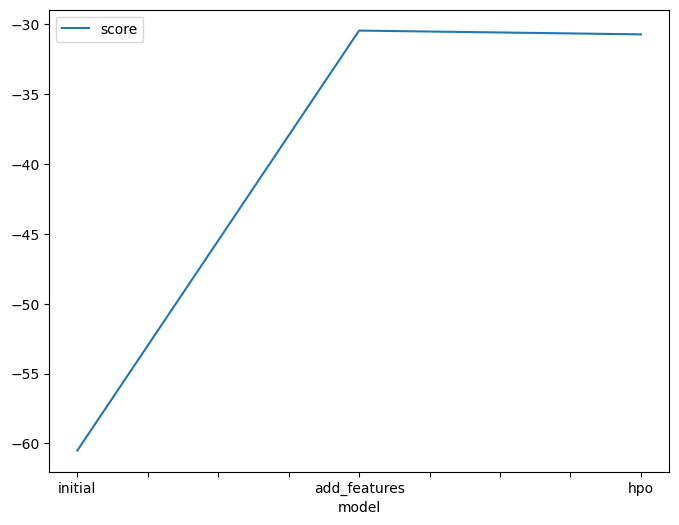

In [42]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [-60.515724, -30.459972 , -30.730602]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

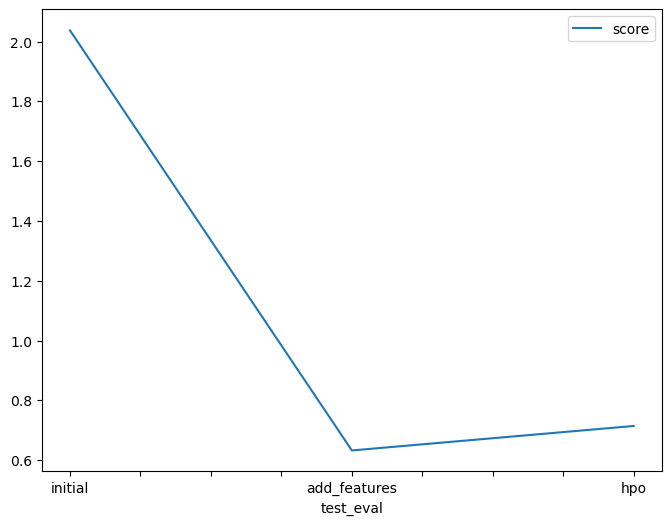

In [43]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [2.03740,0.63233,0.71417]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

In [44]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": [8, 8, 5],
    "hpo2": [3, 3, 3],
    "hpo3": [20, 20, 10],
    "score": [2.03740,0.63233,0.71417]
})

,model,hpo1,hpo2,hpo3,score
0,initial,8,3,20,2.03740
1,add_features,8,3,20,0.63233
2,hpo,5,3,10,0.71417
